In [30]:
%matplotlib inline

In [31]:
import numpy as np
import scipy.io

# Load data from CSV file using NumPy
data = np.genfromtxt(r'E:\Thesis\python-meegkit\tests\data\ssvep-10trials-3s-chaky-bigsquare.csv', delimiter=',')

# Save data to MATLAB .mat file using scipy.io.savemat
scipy.io.savemat(r'E:\Thesis\python-meegkit\tests\data\chaky_data.mat', {'data': data})



# Task-related component analysis for SSVEP detection

Sample code for the task-related component analysis (TRCA)-based steady
-state visual evoked potential (SSVEP) detection method [1]_. The filter
bank analysis can also be combined to the TRCA-based algorithm [2]_ [3]_.

This code is based on the Matlab implementation from:
https://github.com/mnakanishi/TRCA-SSVEP

Uses `meegkit.trca.TRCA()`.

References:

.. [1] M. Nakanishi, Y. Wang, X. Chen, Y.-T. Wang, X. Gao, and T.-P. Jung,
   "Enhancing detection of SSVEPs for a high-speed brain speller using
   task-related component analysis", IEEE Trans. Biomed. Eng, 65(1): 104-112,
   2018.

.. [2] X. Chen, Y. Wang, S. Gao, T. -P. Jung and X. Gao, "Filter bank
   canonical correlation analysis for implementing a high-speed SSVEP-based
   brain-computer interface", J. Neural Eng., 12: 046008, 2015.
   
.. [3] X. Chen, Y. Wang, M. Nakanishi, X. Gao, T. -P. Jung, S. Gao,
   "High-speed spelling with a noninvasive brain-computer interface",
   Proc. Int. Natl. Acad. Sci. U. S. A, 112(44): E6058-6067, 2015.


In [32]:
# Authors: Giuseppe Ferraro <giuseppe.ferraro@isae-supaero.fr>
#          Nicolas Barascud <nicolas.barascud@gmail.com>
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from meegkit.trca import TRCA
from meegkit.utils.trca import itr, normfit, round_half_up

t = time.time()

In [33]:
import matplotlib.pyplot as plt
import mne
import numpy as np
from scipy.stats import ttest_rel
import scipy.io
from mne.channels import make_standard_montage
from mne import create_info
from mne.io import RawArray
import pandas as pd

In [34]:
df = pd.read_csv(r'E:\Thesis\python-meegkit\tests\data\ssvep-10trials-3s-chaky-bigsquare.csv')

In [35]:
df.rename(columns={'Unnamed: 1':'O1',
                          'Unnamed: 2':'Oz',
                          'Unnamed: 3':'O2'
                      }, 
                 inplace=True)

In [36]:
df = df.drop(["timestamps", "Unnamed: 4", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8"], axis=1)

In [37]:
df.head()

,O1,Oz,O2,Marker
0,58600.641,53608.289,49404.219,0
1,58582.133,53588.531,49381.977,0
2,58619.953,53622.977,49414.520,0
3,58660.992,53663.207,49452.832,0
4,58645.566,53651.676,49443.469,0


In [38]:
def df_to_raw(df):
    sfreq = 250
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T  #mne looks at the tranpose() format
    df[:-1] *= 1e-6  #convert from uVolts to Volts (mne assumes Volts data)

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #try plotting the raw data of its power spectral density
    raw.plot_psd()
    plt.show()
    return raw

Creating RawArray with float64 data, n_channels=4, n_times=32952
    Range : 0 ... 32951 =      0.000 ...   131.804 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


c:\Users\Sunsun\AppData\Local\Programs\Python\Python38\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


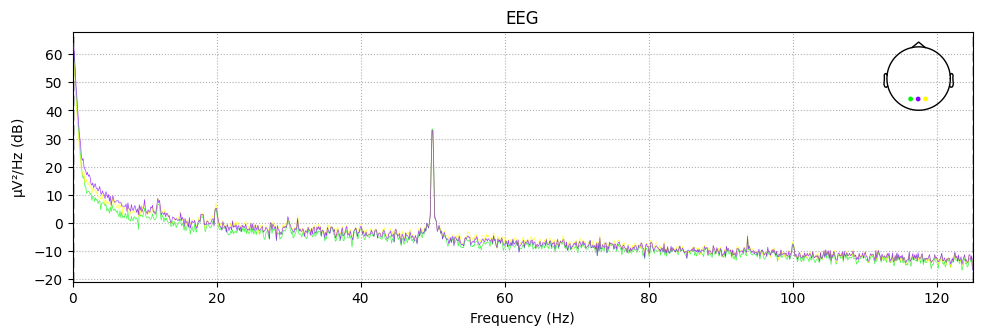

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
c:\Users\Sunsun\AppData\Local\Programs\Python\Python38\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


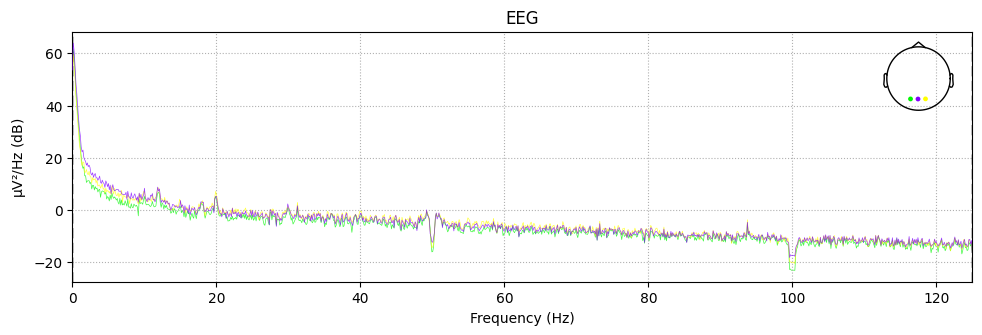

In [39]:
raw = df_to_raw(df)
raw.notch_filter([50,100])
raw.plot_psd()
plt.show()

In [40]:
events = mne.find_events(raw)
# epochs = mne.Epochs(raw=raw,events=events, baseline=None, tmin=-0.5, tmax=3 - 1/250, reject=None, reject_by_annotation=False)
epochs = mne.Epochs(raw=raw,events=events, baseline=None, tmin=2, tmax=3)
data = epochs.get_data()

print(data.shape)


# 

30 events found
Event IDs: [1 2 3]
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 251 original time points ...
0 bad epochs dropped
(30, 4, 251)


## Parameters



In [41]:
eeg = data
events = mne.find_events(raw)
# print(events)
labels = events[:,-1]
print(labels)

30 events found
Event IDs: [1 2 3]
[1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3]


In [42]:
dur_gaze = 0.5  # data length for target identification [s]
delay = 0.13  # visual latency being considered in the analysis [s]
n_bands = 5  # number of sub-bands in filter bank analysis
is_ensemble = True  # True = ensemble TRCA method; False = TRCA method
alpha_ci = 0.05   # 100*(1-alpha_ci): confidence interval for accuracy
sfreq = 250  # sampling rate [Hz]
dur_shift = 0.5  # duration for gaze shifting [s]
# list_freqs = np.array(
#     [[x + 8.0 for x in range(8)],
#      [x + 8.2 for x in range(8)],
#      [x + 8.4 for x in range(8)],
#      [x + 8.6 for x in range(8)],
#      [x + 8.8 for x in range(8)]]).T  # list of stimulus frequencies
list_freqs = np.array([6, 10, 15])
n_targets = list_freqs.size  # The number of stimuli

# Useful variables (no need to modify)
dur_gaze_s = round_half_up(dur_gaze * sfreq)  # data length [samples]
delay_s = round_half_up(delay * sfreq)  # visual latency [samples]
dur_sel_s = dur_gaze + dur_shift  # selection time [s]
ci = 100 * (1 - alpha_ci)  # confidence interval

## Load data



In [43]:
# path = os.path.join('..', 'tests', 'data', 'trcadata.mat')
# eeg = scipy.io.loadmat(path)["eeg"]
# print(eeg.shape)

# n_trials, n_chans, n_samples, n_blocks = eeg.shape

# # Convert dummy Matlab format to (sample, channels, trials) and construct
# # vector of labels
# eeg = np.reshape(eeg.transpose([2, 1, 3, 0]),
#                  (n_samples, n_chans, n_trials * n_blocks))
# labels = np.array([x for x in range(n_targets)] * n_blocks)
# crop_data = np.arange(delay_s, delay_s + dur_gaze_s)
# eeg = eeg[crop_data]

In [44]:
# n_trials = 30
# n_blocks = 1

print(data.shape, labels.shape)
print(data[:,0:3,:].shape, labels.shape)
labels = labels - 1
labels

(30, 4, 251) (30,)
(30, 3, 251) (30,)


array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2, 0, 1, 2], dtype=int64)

In [45]:
# from sklearn.model_selection import train_test_split


# X_train, X_test, y_train, y_test = train_test_split(data[:,:3,:], labels, test_size=0.5)
# X_train = np.swapaxes(X_train, 0,2)
# X_test = np.swapaxes(X_test, 0,2)
# X_train.shape, y_train.shape, X_test.shape, y_test.shape
X = data[:,:3,:]
X_new = np.swapaxes(X, 0,2)
y = labels

In [46]:
print(X.shape)
print(X_new.shape)
print(y.shape)

(30, 3, 251)
(251, 3, 30)
(30,)


In [53]:
filterbank = [[(6, 90), (4, 100)],  # passband, stopband freqs [(Wp), (Ws)]
              [(14, 90), (10, 100)],
              [(22, 90), (16, 100)],
              [(30, 90), (24, 100)],
              [(38, 90), (32, 100)],
              [(46, 90), (40, 100)],
              [(54, 90), (48, 100)]]
# 'schaefer', 'lwf', 'oas'. 'scm' 
# 'original'| 'riemann'
trca = TRCA(sfreq, filterbank, is_ensemble, method="riemann", estimator='schaefer')
# trca = TRCA(sfreq, filterbank, is_ensemble, method="crosscorrelation")
# trca = TRCA(sfreq, filterbank, is_ensemble, method='original')
# trca.fit(data[:,0:3,:], labels - 1 )

In [54]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
print(skf)
accs = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: ", y[train_index])
    print(f"  Test: ", y[test_index])
    print(X[train_index].shape)
    X_train = np.swapaxes(X[train_index], 0,2)
    X_test = np.swapaxes(X[test_index],0,2)
    model = trca.fit(X_train, y[train_index])
    preds = model.predict(X_test)
    acc = np.mean(preds == y[test_index])
    accs.append(acc)
    print(y[test_index])
    print(preds)
    print(acc)
print("Average accuracy ==>", np.mean(accs))

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
Fold 0:
  Train:  [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2]
  Test:  [0 1 2 0 1 2]
(24, 3, 251)
class 0
class 1
class 2
[0 1 2 0 1 2]
[1 0 2 2 1 2]
0.5
Fold 1:
  Train:  [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2]
  Test:  [0 1 2 0 1 2]
(24, 3, 251)
class 0
class 1
class 2
[0 1 2 0 1 2]
[0 1 2 0 0 2]
0.8333333333333334
Fold 2:
  Train:  [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2]
  Test:  [0 1 2 0 1 2]
(24, 3, 251)
class 0
class 1
class 2
[0 1 2 0 1 2]
[1 0 0 1 1 0]
0.16666666666666666
Fold 3:
  Train:  [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2]
  Test:  [0 1 2 0 1 2]
(24, 3, 251)
class 0
class 1
class 2
[0 1 2 0 1 2]
[2 1 0 0 0 1]
0.3333333333333333
Fold 4:
  Train:  [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2]
  Test:  [0 1 2 0 1 2]
(24, 3, 251)
class 0
class 1
class 2
[0 1 2 0 1 2]
[0 0 0 1 1 2]
0.5
Average accuracy ==> 0.4666666666666667


## TRCA classification
Estimate classification performance with a Leave-One-Block-Out
cross-validation approach.

To get a sense of the filterbank specification in relation to the stimuli
we can plot the individual filterbank sub-bands as well as the target
frequencies (with their expected harmonics in the EEG spectrum). We use the
filterbank specification described in [2]_.



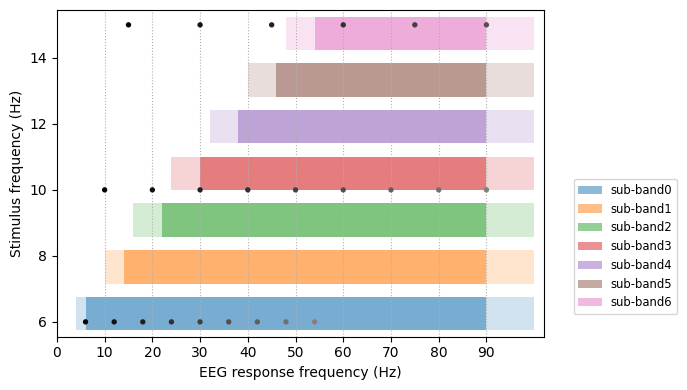

In [49]:
filterbank = [[(6, 90), (4, 100)],  # passband, stopband freqs [(Wp), (Ws)]
              [(14, 90), (10, 100)],
              [(22, 90), (16, 100)],
              [(30, 90), (24, 100)],
              [(38, 90), (32, 100)],
              [(46, 90), (40, 100)],
              [(54, 90), (48, 100)]]

f, ax = plt.subplots(1, figsize=(7, 4))
for i, band in enumerate(filterbank):
    ax.axvspan(ymin=i / len(filterbank) + .02,
               ymax=(i + 1) / len(filterbank) - .02,
               xmin=filterbank[i][1][0], xmax=filterbank[i][1][1],
               alpha=0.2, facecolor=f'C{i}')
    ax.axvspan(ymin=i / len(filterbank) + .02,
               ymax=(i + 1) / len(filterbank) - .02,
               xmin=filterbank[i][0][0], xmax=filterbank[i][0][1],
               alpha=0.5, label=f'sub-band{i}', facecolor=f'C{i}')

for f in list_freqs.flat:
    colors = np.ones((9, 4))
    colors[:, :3] = np.linspace(0, .5, 9)[:, None]
    ax.scatter(f * np.arange(1, 10), [f] * 9, c=colors, s=8, zorder=100)

ax.set_ylabel('Stimulus frequency (Hz)')
ax.set_xlabel('EEG response frequency (Hz)')
ax.set_xlim([0, 102])
ax.set_xticks(np.arange(0, 100, 10))
ax.grid(True, ls=':', axis='x')
ax.legend(bbox_to_anchor=(1.05, .5), fontsize='small')
plt.tight_layout()
plt.show()

Now perform the TRCA-based SSVEP detection algorithm



In [50]:
trca = TRCA(sfreq, filterbank, is_ensemble)

print('Results of the ensemble TRCA-based method:\n')
accs = np.zeros(n_blocks)
itrs = np.zeros(n_blocks)
for i in range(n_blocks):

    # Select all folds except one for training
    traindata = np.concatenate(
        (eeg[..., :i * n_trials],
         eeg[..., (i + 1) * n_trials:]), 2)
    y_train = np.concatenate(
        (labels[:i * n_trials], labels[(i + 1) * n_trials:]), 0)
    print(traindata.shape)
    print(y_train.shape)
    break
    # Construction of the spatial filter and the reference signals
    trca.fit(traindata, y_train)

    # Test stage
    testdata = eeg[..., i * n_trials:(i + 1) * n_trials]
    y_test = labels[i * n_trials:(i + 1) * n_trials]
    estimated = trca.predict(testdata)

    # Evaluation of the performance for this fold (accuracy and ITR)
    is_correct = estimated == y_test
    accs[i] = np.mean(is_correct) * 100
    itrs[i] = itr(n_targets, np.mean(is_correct), dur_sel_s)
    print(f"Block {i}: accuracy = {accs[i]:.1f}, \tITR = {itrs[i]:.1f}")

# Mean accuracy and ITR computation
mu, _, muci, _ = normfit(accs, alpha_ci)
print(f"\nMean accuracy = {mu:.1f}%\t({ci:.0f}% CI: {muci[0]:.1f}-{muci[1]:.1f}%)")  # noqa

mu, _, muci, _ = normfit(itrs, alpha_ci)
print(f"Mean ITR = {mu:.1f}\t({ci:.0f}% CI: {muci[0]:.1f}-{muci[1]:.1f})")
if is_ensemble:
    ensemble = 'ensemble TRCA-based method'
else:
    ensemble = 'TRCA-based method'

print(f"\nElapsed time: {time.time()-t:.1f} seconds")

Results of the ensemble TRCA-based method:



NameError: name 'n_blocks' is not defined